# Классификация текста с помощью трансформера BERT

Оригинальная идея подчерпнута отсюда https://www.kaggle.com/c/learn-ai-bbc и отсюда https://habr.com/ru/post/655517/


### Импорт библиотек

In [1]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from bs4 import BeautifulSoup


tqdm.pandas()

device = torch.device('cuda')
print(device)

cuda


### Чтение нашего датасета, состоящего из html и лейблов в txt файле

В файле две строки

Первая:
 - Label 0 - Маркет
 - Label 1 - Сайт
 - Label 2 - Мусор


Вторая: 
 - Label 0 - Производитель
 - Label 1 - Перекуп

Сейчас работаем по **второй**

In [2]:
indir = 'dataset2'
indir = os.path.abspath(indir)

sites = [x for x in os.listdir(indir) if x.endswith('.txt')]

pairs = []

for pair in sites:
    site = os.path.splitext(pair)[0] + '.html'
    

    with open(os.path.join(indir, site)) as f:
        lines = f.read().rstrip().replace(' - ','').replace(' | ', '')
        clean_text = ' '.join(BeautifulSoup(lines, "html.parser").stripped_strings)
        
    with open(os.path.join(indir, pair)) as f:
        lines = f.readlines()
        label = int(lines[1])
        
    pairs.append([clean_text, label])

#print(pairs)

df = pd.DataFrame(pairs, columns = ['text', 'target'])

display(df)


,text,target
0,Рукав газовый ( шланг) купить в Москве со скид...,1
1,КонтактыООО«Торговый дом«Снабжение» Обратная с...,0
2,Крепеж STRONG КАТАЛОГ О НАС ДОСТАВКА И ОПЛАТА ...,1
3,Главная страница Торговый дом РТИ (Санкт-Петер...,0
4,Сварочные инверторы TIG AC/DC купить в Москве....,1
5,"Шайба плоская цена, купить в России от ТрубТех...",1
6,"Метизы цена, купить в РоссииМеталлЭнергоХолдин...",0
7,Gesacофициальный дистрибьютор в России НАШИ ПР...,1
8,"заказать шплинт,шайбу,гровер О нас Новости Кон...",0
9,"Оборудование щеточное, Навесное оборудование д...",1


Загрузка претренированной модели

In [3]:
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

Разбиение выборок на текст и таргет

In [4]:
X = df['text'].astype('str')
y = df['target'].astype(int)

X_train, y_train = X,y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=99)

График длин текстов. Он поможет определить оптимальную длину последовательности токенов, чтобы избежать разреженных векторов.

<AxesSubplot:>

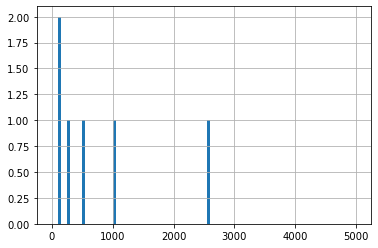

In [5]:
seq_len = [len(str(i).split()) for i in X_train]
pd.Series(seq_len).hist(bins = 100, range =(0,5000))

Токенизация текста
Берем длину 500 (эта реализация BERT не дает сделать больше 512 к сожалению)

In [6]:
token_len = 500

tokens_train = tokenizer.batch_encode_plus(
    X_train.values,
    max_length = token_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    X_test.values,
    max_length = token_len,
    padding = 'max_length',
    truncation = True
)

Создание датасета для обучения из токенов

In [7]:
batch_size = 2


train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.values)

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

test_data =  TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [8]:
#print(test_data[0])

Вместо обучения всего BERT добавим слой для классификации

In [9]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

Загрузка модели в GPU

In [10]:
model = BERT_Arch(bert)

model = model.to(device)
from torch.optim import AdamW

optimizer = AdamW(model.parameters())

Нормализация весов в зависимости от соотношения 0/1 в выборке трейна

In [11]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
#cross_entropy = nn.CrossEntropyLoss()
cross_entropy = nn.NLLLoss(weight=weights)
epochs = 20

[1.16666667 0.875     ]


/home/eugene/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=2    1
6    0
7    1
0    1
9    1
3    0
1    0
Name: target, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Функция для наглядного обучения модели

In [12]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

Функция для тестирования модели

In [13]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    
    return avg_loss, total_preds

Обучение новых слоев для задачи классификации

In [14]:
best_test_loss = float('inf')

train_losses = []
test_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    test_loss, _ = evaluate()
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Test loss: {test_loss:.3f}')
    
    
    
    
def acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

a,b = acc()


 Epoch1 / 20


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]



Training loss: 1.020
Test loss: 0.778

 Epoch2 / 20


100%|██████████| 2/2 [00:00<00:00, 23.05it/s]



Training loss: 0.794
Test loss: 0.619

 Epoch3 / 20


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]



Training loss: 0.686
Test loss: 0.723

 Epoch4 / 20


100%|██████████| 2/2 [00:00<00:00, 22.80it/s]



Training loss: 0.705
Test loss: 0.742

 Epoch5 / 20


100%|██████████| 2/2 [00:00<00:00, 22.48it/s]



Training loss: 0.599
Test loss: 0.658

 Epoch6 / 20


100%|██████████| 2/2 [00:00<00:00, 22.77it/s]



Training loss: 0.654
Test loss: 0.609

 Epoch7 / 20


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]



Training loss: 0.615
Test loss: 0.645

 Epoch8 / 20


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]



Training loss: 0.547
Test loss: 0.653

 Epoch9 / 20


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]



Training loss: 0.574
Test loss: 0.684

 Epoch10 / 20


100%|██████████| 2/2 [00:00<00:00, 22.82it/s]



Training loss: 0.501
Test loss: 0.683

 Epoch11 / 20


100%|██████████| 2/2 [00:00<00:00, 22.76it/s]



Training loss: 0.495
Test loss: 0.647

 Epoch12 / 20


100%|██████████| 2/2 [00:00<00:00, 22.85it/s]



Training loss: 0.421
Test loss: 0.604

 Epoch13 / 20


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]



Training loss: 0.434
Test loss: 0.563

 Epoch14 / 20


100%|██████████| 2/2 [00:00<00:00, 23.03it/s]



Training loss: 0.480
Test loss: 0.476

 Epoch15 / 20


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]



Training loss: 0.334
Test loss: 0.479

 Epoch16 / 20


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]



Training loss: 0.372
Test loss: 0.514

 Epoch17 / 20


100%|██████████| 2/2 [00:00<00:00, 22.78it/s]



Training loss: 0.301
Test loss: 0.497

 Epoch18 / 20


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]



Training loss: 0.314
Test loss: 0.559

 Epoch19 / 20


100%|██████████| 2/2 [00:00<00:00, 22.90it/s]



Training loss: 0.241
Test loss: 0.741

 Epoch20 / 20


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]



Training loss: 0.174
Test loss: 0.644


100%|██████████| 2/2 [00:00<00:00, 22.59it/s]

Test Accuracy:  0.667


Загружаем лучшую модель для предсказания

In [15]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))
model.eval()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

Предсказываем для сайтов

In [16]:
# Для демо читаем сохраненные файлы с диска, в реальном ПО можно подать просто html

sites = ['dataset2/a8.html', 'dataset2/a9.html', 'dataset2/a3.html', 'dataset2/a4.html', 'dataset2/a7.html']
texts = []

for s in sites:
    with open(s) as f:
        lines = f.read()
        lines = lines.rstrip().replace(' - ','').replace(' | ', '')
        clean_text = ' '.join(BeautifulSoup(lines, "html.parser").stripped_strings)
        texts.append([clean_text])

pred_df = pd.DataFrame(texts, columns = ['text'])
display(pred_df)

def predict(df):
    """
    Берем из pandas таблицы столбец text, в котором текст сайта
    добавляев в pandas таблицу столбец target, в котором 0 - маркетплейс, 1 - сайт поставщика
    """
    df = df.copy()
    batch_size = 1
    tokens_predict = tokenizer.batch_encode_plus(
        df['text'].values,
        max_length = 500,
        padding = 'max_length',
        truncation = True
    )
    
    total_preds = []
    
    predict_seq = torch.tensor(tokens_predict['input_ids'])
    predict_mask = torch.tensor(tokens_predict['attention_mask'])
    predict_data =  TensorDataset(predict_seq, predict_mask)
    predict_sampler = SequentialSampler(predict_data)
    predict_dataloader = DataLoader(predict_data, sampler = predict_sampler, batch_size = batch_size)
    
    
    for step, batch in tqdm(enumerate(predict_dataloader), total = len(predict_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()    
            preds = np.argmax(preds)
            total_preds.append(preds)
    df['target'] = total_preds
    return df


pred_df = predict(pred_df)
display(pred_df)





,text
0,"заказать шплинт,шайбу,гровер О нас Новости Кон..."
1,Главная страница Торговый дом РТИ (Санкт-Петер...
2,Рукав газовый ( шланг) купить в Москве со скид...
3,"Оборудование щеточное, Навесное оборудование д..."
4,Крепеж STRONG КАТАЛОГ О НАС ДОСТАВКА И ОПЛАТА ...


100%|██████████| 5/5 [00:00<00:00, 32.70it/s]


,text,target
0,"заказать шплинт,шайбу,гровер О нас Новости Кон...",1
1,Главная страница Торговый дом РТИ (Санкт-Петер...,0
2,Рукав газовый ( шланг) купить в Москве со скид...,1
3,"Оборудование щеточное, Навесное оборудование д...",1
4,Крепеж STRONG КАТАЛОГ О НАС ДОСТАВКА И ОПЛАТА ...,1
